# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Read-combined-imcat-catalog-of-400-files-after-pre-processing-dmstack-output-csvs" data-toc-modified-id="Read-combined-imcat-catalog-of-400-files-after-pre-processing-dmstack-output-csvs-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Read combined imcat catalog of 400 files after pre-processing dmstack output csvs</a></div><div class="lev1 toc-item"><a href="#Ellipticity-components" data-toc-modified-id="Ellipticity-components-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Ellipticity components</a></div><div class="lev1 toc-item"><a href="#Create-new-columns" data-toc-modified-id="Create-new-columns-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create new columns</a></div><div class="lev1 toc-item"><a href="#Distribution-of-gm_sq" data-toc-modified-id="Distribution-of-gm_sq-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Distribution of gm_sq</a></div><div class="lev1 toc-item"><a href="#Radius-distribution-of-mono-for-bad-objects-with-0.7-<-gm_sq-<-1.0" data-toc-modified-id="Radius-distribution-of-mono-for-bad-objects-with-0.7-<-gm_sq-<-1.0-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Radius distribution of mono for bad objects with 0.7 &lt; gm_sq &lt; 1.0</a></div><div class="lev1 toc-item"><a href="#Bucketing-equal-number-of-objects-in-bins-after-sorting-flux" data-toc-modified-id="Bucketing-equal-number-of-objects-in-bins-after-sorting-flux-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Bucketing equal number of objects in bins after sorting flux</a></div><div class="lev1 toc-item"><a href="#Look-at-the-bucket25-with-dense-population-at-gmSquared-0.7-to-1.0" data-toc-modified-id="Look-at-the-bucket25-with-dense-population-at-gmSquared-0.7-to-1.0-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Look at the bucket25 with dense population at gmSquared 0.7 to 1.0</a></div><div class="lev1 toc-item"><a href="#Read-just-one-lsst_mono-and-lsst_mono90-catalog-files" data-toc-modified-id="Read-just-one-lsst_mono-and-lsst_mono90-catalog-files-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Read just one lsst_mono and lsst_mono90 catalog files</a></div>

# Introduction
Date: Aug 1, 2019

In jedisim we used ngals = 10k, z = 1.5 and did 100 simulations. 
jedisim gives l,l9,m,m9 fitsfiles for each 100 simulations (total 100*4 = 400 fitsfiles).

Dmstack gives 400 csv files from 400 jedisim outputs. Each csv output has 90 flags and 76 parameters.

After dmstack we clean and filter csv fiels to get txt files with few columns of interest.

- no nans
- e <= 1.5,
- not psf candidate
- have no child.

We combined four txt files l.txt, l9.txt, m.txt, m9.txt in IMCAT and get final0.cat,
final1.cat, ..., final99.cat etc. Four text files give one cat file.
Finally, we also combine 100 final.cat files to get one big catalog file called `final.cat`
and then convert it to text format and call it `final_text.txt`.

The output of imcat program `final_text.txt` has more columns than txt output of processed dmstack output.

```
fN     00 10 20 30  # fN means file number
id     00 10 20 30
flux   00 10 20 30
ellip  00 10 20 30
radius 00 10 20 30

x  0 1
gm 0 1
gc 0 1

errx 00 01 10 11 20 21 30 31
g    00 01 10 11 20 21 30 31 # there is no erry here in imcat output

So, in total there are following number of columns in final_text.cat file
5 * 4 + 3 * 2 + 2 * 8 
= 20  + 6     + 16 
= 42 columns
```

**Imcat commands**
```bash
# First we get dmstack output in l.csv which have 90 flags + 76 parameters.
# Then, we choose only few parameters, remove nans, and change delimiter from comma to tab.
#
# python remove_nans_dmstack.py l.csv gives l.txt from l.csv file.
#==================================================
# Input file src_lsst_z1.5_000.txt (NOTE: we need l.csv,l9.csv,m.csv,m9.csv for this script)
#
# column 0,1 :   fN = file_number, id = id
# column 2,3:   x = base_SdssCentroid_x, base_SdssCentroid_y
# column 4,5:  errx = base_SdssCentroid_xSigma, base_SdssCentroid_ySigma
# column 6,7,8:  ellip = ext_shapeHSM_HsmShapeRegauss_e1, ext_shapeHSM_HsmShapeRegauss_e2, ellip
# column 9:   flux = base_SdssShape_flux
#                   there are other flux e.g.
#                   base_CicularApertureFlux_3_0_flux, 4.5,6.0,9.0,12.0 etc
#                   base_GaussianFlux_flux
#                   I checked sdss vs gaussian scatterplot, they look linearly dependent, so
#                   we can use either of them, but I am using sdss.
#column10: radius = 4th root of (xx*xy - xy*xy)
#
#==================================================
# NOTE: here we denote ellipticiy e as g.
#             In physics, the reduced shear in weak lensing limit is g = e/2.
#            and e=sqrt(e1**2+e2**2) a
#           <e_i>/2 ~ g_i   where index i is t or c i.e. tangential or cross components.
#           This means in our ouptput column g is actually e and real g is g/2 or e/2.
#
#==================================================
# Required: This program needs four text files e.g. l.txt,l9.txt,m.txt and m9.txt
# Outputs: final.cat (also temporary outputs e.g. l,l9,m,m9.cat and merge.cat)

z=1.5
BEGIN=0
END=99 # end is included

# main output folder
mkdir -p final

# loop through range of files
for i in $(seq -f "%03g" $BEGIN $END)
do
L="src_lsst_z${z}_${i}"
L9="src_lsst90_z${z}_${i}"
M="src_lsst_mono_z${z}_${i}"
M9="src_lsst_mono90_z${z}_${i}"

# create lc catalog from text file
# in imcat we must read all columns
# unused columns further: id flux radius
#echo "Creating: .cat files";
lc -C -n fN -n id -N '1 2 x' -N '1 2 errx' -N '1 2 g' -n ellip -n flux -n radius < "${L}".txt > "${L}".cat
lc -C -n fN -n id -N '1 2 x' -N '1 2 errx' -N '1 2 g' -n ellip -n flux -n radius < "${L9}".txt > "${L9}".cat

lc -C -n fN -n id -N '1 2 x' -N '1 2 errx' -N '1 2 g' -n ellip -n flux -n radius < "${M}".txt > "${M}".cat
lc -C -n fN -n id -N '1 2 x' -N '1 2 errx' -N '1 2 g' -n ellip -n flux -n radius < "${M9}".txt > "${M9}".cat

# merge the 4 catalogs to a single catalog
# Make sure mergecats have mono files first and then chromatic files later
# to comply with the command to create final.cat.
#echo "Creating: merge.cat"
mergecats 5 "${M}".cat "${M9}".cat "${L}".cat "${L9}".cat > merge.cat &&
#echo "Created: merge.cat"

# convert the merge catalog into a catalog with mono and color shear values with the 0 degree and 90 degree values averaged:
#echo "Creating: final.cat";
lc -b +all 'x = %x[0][0] %x[1][0] + %x[2][0] + %x[3][0] + 4 / %x[0][1] %x[1][1] + %x[2][1] + %x[3][1] + 4 / 2 vector' 'gm = %g[0][0] %g[1][0] + 2 / %g[0][1] %g[1][1] + 2 / 2 vector' 'gc = %g[2][0] %g[3][0] + 2 / %g[2][1] %g[3][1] + 2 / 2 vector' < merge.cat > final/final_${i}.cat

echo "Created: final/final_${i}.cat"
done;

# combine all cats
cd final;
catcats *.cat > final.cat

# convert binary to text
lc -O < final.cat > final_text.txt 



#lc -c < catalog

#plotting values:
#plotcat var1 var2 < catalog
#(var1 is x axis, var2 is y axis, can just give a single vector variable name and get plots of x vs y for that vector)
#(can restrict the plotted region by adding a flag “-x x0 x1 y0 y1” after the variable names)

# Required: four txt files of l,l9,m,m9 from dmstack and filtering nans.
# Command: bash mycommands.sh
# output: final.cat (other .cat files are temporary outputs)
```

**merge.cat columns**
```
# NOTE: mono   mono90         lsst           lsst90
# mergecats combines 4 files: m,m9,l and l9 and creates a big files with more columns.
#
fN[0][0]       fN[1][0]       fN[2][0]       fN[3][0]       
id[0][0]       id[1][0]       id[2][0]       id[3][0]
x[0][0]        x[0][1]        x[1][0]        x[1][1]       x[2][0]    x[2][1]    x[3][0]     x[3][1]
errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]    errx[2][0] errx[2][1] errx[3][0]  errx[3][1]
g[0][0]        g[0][1]        g[1][0]        g[1][1]       g[2][0]    g[2][1]    g[3][0]     g[3][1]
ellip[0][0]    ellip[1][0]    ellip[2][0]    ellip[3][0]
flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]
radius[0][0]   radius[1][0]   radius[2][0]   radius[3][0]
```

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# look at combination of 100*4 catalog files from icmat
!head -n 2 ../../a08_july5_2019/final/final_text.txt

#       fN[0][0]       fN[1][0]       fN[2][0]       fN[3][0]       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]    ellip[0][0]    ellip[1][0]    ellip[2][0]    ellip[3][0]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]   radius[0][0]   radius[1][0]   radius[2][0]   radius[3][0]          gm[0]          gm[1]          gc[0]          gc[1]
               0              0              0              0           5678           5735           5568           5678      1969.2159      2159.7569         0.1046         0.0759         0.1063         0.0745         0.1055         0.0759          0.107         0.0746          1.083        -0.2341         1.1499        -0.4244         1.1705        -0.2617       

In [4]:
!tail -n 1 ../../a08_july5_2019/final/final_text.txt

              99             99             99             99           3565            487           3546            486      1012.9914      668.48905         0.1321         0.1634         0.2443         0.2245         0.1336         0.1664          0.165         0.1341         0.0185          0.745         0.3311         0.3349         0.0605         0.7665         0.3397         0.3455     0.74522966     0.47094078     0.76888393     0.48452692      7363.0329      8192.7381      7288.0971       7581.061      5.3444724      5.4433975      5.4180537      5.4658871         0.1748        0.53995         0.2001          0.556


# Read combined imcat catalog of 400 files after pre-processing dmstack output csvs

In [5]:
# final_text is obtained from imcat after combining l,l9,m,m9 files
df = pd.read_csv('../../a08_july5_2019/final/final_text.txt',sep=r'\s+',
                 comment='#',header=None)
print(df.shape)
df.head()

(183832, 42)


0   1   2   3     4     5     6     7           8           9    ...     \
0   0   0   0   0  5678  5735  5568  5678  1969.21590  2159.75690   ...      
1   0   0   0   0  3181  3193  3164  3179  2222.70820   480.46175   ...      
2   0   0   0   0   617   629   634   631  2490.22380   808.50175   ...      
3   0   0   0   0   684   696   699   698  3373.27020   905.54893   ...      
4   0   0   0   0  7439  7449  7225  7379   469.49428  3091.40550   ...      

           32          33        34        35        36        37       38  \
0   8109.6423   8206.3494  3.990534  4.020170  3.987262  4.020873  1.11645   
1  53930.3800  53825.1630  3.824574  3.820401  3.820253  3.815395  0.09625   
2   1981.6793   2005.1267  3.643384  3.651113  3.555529  3.603011 -0.30090   
3   6556.4337   6549.9094  3.529530  3.531219  3.530856  3.532656 -0.15520   
4   5279.9345   5064.7001  4.001462  3.860184  4.002095  3.864219  0.01340   

        39       40       41  
0 -0.32925  1.19050 -0.35375  
1  0.05815  0.08565  0.06530  
2 -0.46295 -0.34460 -0.37255  
3 -0.07390 -0.17915 -0.16215  
4  0.03275  0.00085  0.03555  

[5 rows x 42 columns]

In [6]:
colnames = """fN[0][0]       fN[1][0]       fN[2][0]       fN[3][0]
id[0][0]       id[1][0]       id[2][0]       id[3][0]
x[0] x[1]     
errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]
errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]
g[0][0]        g[0][1]        g[1][0]        g[1][1] 
g[2][0]        g[2][1]        g[3][0]        g[3][1]
ellip[0][0]    ellip[1][0]    ellip[2][0]    ellip[3][0]
flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]
radius[0][0]   radius[1][0]   radius[2][0]   radius[3][0]
gm[0]          gm[1]          gc[0]          gc[1]
""".split()

colnames = [i.strip() for i in colnames]
df.columns = colnames
df.head(2).append(df.tail(2)).T

0             1             183830       183831
fN[0][0]         0.000000      0.000000     99.000000    99.000000
fN[1][0]         0.000000      0.000000     99.000000    99.000000
fN[2][0]         0.000000      0.000000     99.000000    99.000000
fN[3][0]         0.000000      0.000000     99.000000    99.000000
id[0][0]      5678.000000   3181.000000   7429.000000  3565.000000
id[1][0]      5735.000000   3193.000000   7423.000000   487.000000
id[2][0]      5568.000000   3164.000000   7347.000000  3546.000000
id[3][0]      5678.000000   3179.000000   7327.000000   486.000000
x[0]          1969.215900   2222.708200    628.173320  1012.991400
x[1]          2159.756900    480.461750   3170.700700   668.489050
errx[0][0]       0.104600      0.008400      0.025200     0.132100
errx[0][1]       0.075900      0.008000      0.023600     0.163400
errx[1][0]       0.106300      0.007800      0.013600     0.244300
errx[1][1]       0.074500      0.008600      0.017200     0.224500
errx[2][0]       0.105500      0.008300      0.017400     0.133600
errx[2][1]       0.075900      0.008000      0.014500     0.166400
errx[3][0]       0.107000      0.007800      0.013700     0.165000
errx[3][1]       0.074600      0.008600      0.017300     0.134100
g[0][0]          1.083000      0.417400      0.451800     0.018500
g[0][1]         -0.234100      0.642800     -0.561200     0.745000
g[1][0]          1.149900     -0.224900     -0.409900     0.331100
g[1][1]         -0.424400     -0.526500      0.641900     0.334900
g[2][0]          1.170500      0.437800      0.463800     0.060500
g[2][1]         -0.261700      0.652100     -0.575000     0.766500
g[3][0]          1.210500     -0.266500     -0.421400     0.339700
g[3][1]         -0.445800     -0.521500      0.648600     0.345500
ellip[0][0]      1.108013      0.766430      0.720464     0.745230
ellip[1][0]      1.225718      0.572523      0.761613     0.470941
ellip[2][0]      1.199399      0.785432      0.738739     0.768884
ellip[3][0]      1.289980      0.585649      0.773473     0.484527
flux[0][0]    8119.975300  53940.342000  65430.341000  7363.032900
flux[1][0]    8214.591100  53844.274000  65042.717000  8192.738100
flux[2][0]    8109.642300  53930.380000  65522.963000  7288.097100
flux[3][0]    8206.349400  53825.163000  65130.234000  7581.061000
radius[0][0]     3.990534      3.824574      4.762317     5.344472
radius[1][0]     4.020170      3.820401      4.694365     5.443397
radius[2][0]     3.987262      3.820253      4.782234     5.418054
radius[3][0]     4.020873      3.815395      4.713177     5.465887
gm[0]            1.116450      0.096250      0.020950     0.174800
gm[1]           -0.329250      0.058150      0.040350     0.539950
gc[0]            1.190500      0.085650      0.021200     0.200100
gc[1]           -0.353750      0.065300      0.036800     0.556000

In [7]:
# lets look at the id's of objects after mergecats combination of m,m9,l,l9
# the id of different files are different, however the object position is 
# very near to each other and mergecats thinks they are same objects.
ids = 'id[0][0]       id[1][0]       id[2][0]       id[3][0]'.split()
df[ids].head().style.highlight_max(axis=1)

# Ellipticity components

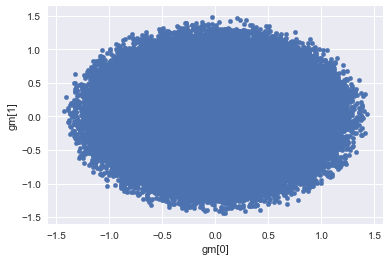

In [8]:
df.plot.scatter(x='gm[0]',y='gm[1]')

# Create new columns

In [9]:
# Find total flux, gm**2 and gc**2
df['flux'] = df['flux[0][0]'] + df['flux[1][0]'] + df['flux[2][0]'] + df['flux[3][0]']
df['gm_sq'] = df['gm[0]']**2 + df['gm[1]']**2
df['gc_sq'] = df['gc[0]']**2 + df['gc[1]']**2
df.head().iloc[:,-5:]

gc[0]    gc[1]         flux     gm_sq     gc_sq
0  1.19050 -0.35375   32650.5581  1.354866  1.542429
1  0.08565  0.06530  215540.1590  0.012645  0.011600
2 -0.34460 -0.37255    7989.1430  0.304864  0.257543
3 -0.17915 -0.16215   26208.0764  0.029548  0.058387
4  0.00085  0.03555   20687.7608  0.001252  0.001265

# Distribution of gm_sq

In [10]:
df['gm_sq'].max(), np.sqrt(df['gm_sq'].max())

(2.19302317, 1.4808859409150996)

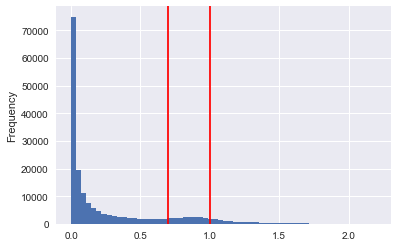

In [11]:
df['gm_sq'].plot.hist(bins=60)
plt.axvline(x=0.7,color='red')
plt.axvline(x=1.0,color='red')

In [12]:
df_07_10 = df.query("0.7 < gm_sq < 1.0")
print('all objects = {:,}'.format(len(df)))
print('bad objects = {:,}'.format(len(df_07_10)))
print('bad objects percentage = {:.2f}% '.format(len(df_07_10)/len(df)*100) )
df_07_10.head(2)

all objects = 183,832
bad objects = 18,386
bad objects percentage = 10.00% 


fN[0][0]  fN[1][0]  fN[2][0]  fN[3][0]  id[0][0]  id[1][0]  id[2][0]  \
14         0         0         0         0      3941      3957      3897   
15         0         0         0         0      2989      3017      2985   

    id[3][0]        x[0]       x[1]    ...     radius[1][0]  radius[2][0]  \
14      3923  3214.45390  930.33603    ...         4.750963      4.675408   
15      2998   241.95747  382.21350    ...         4.189148      4.009824   

    radius[3][0]    gm[0]    gm[1]    gc[0]    gc[1]         flux     gm_sq  \
14      4.751770  0.84675  0.33110  0.85675  0.33405  136044.7920  0.826613   
15      4.181885  0.40780  0.74925  0.41700  0.75615   15450.0079  0.727676   

       gc_sq  
14  0.845610  
15  0.745652  

[2 rows x 45 columns]

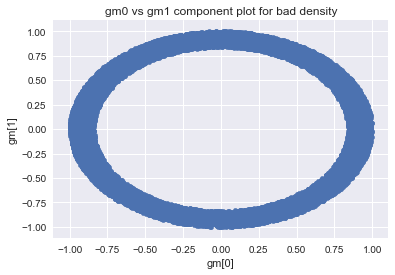

In [13]:
df_07_10.plot.scatter(x='gm[0]',y='gm[1]')
plt.title('gm0 vs gm1 component plot for bad density')

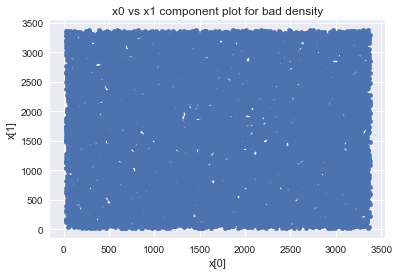

In [36]:
df_07_10.plot.scatter(x='x[0]',y='x[1]')
plt.title('x0 vs x1 component plot for bad density')

# Radius distribution of mono for bad objects with 0.7 < gm_sq < 1.0

In [15]:
df_07_10['radius[1][0]'].describe()

count    18386.000000
mean         4.629727
std          1.161891
min          3.346253
25%          4.000612
50%          4.398421
75%          4.903207
max         23.641727
Name: radius[1][0], dtype: float64

(0.3, 24.0)

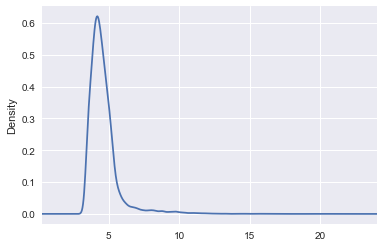

In [16]:
df_07_10['radius[1][0]'].plot.kde()
plt.xlim(0.3,24.0)

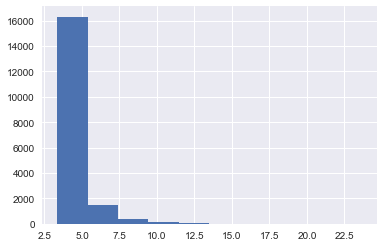

In [17]:
df_07_10['radius[1][0]'].hist()

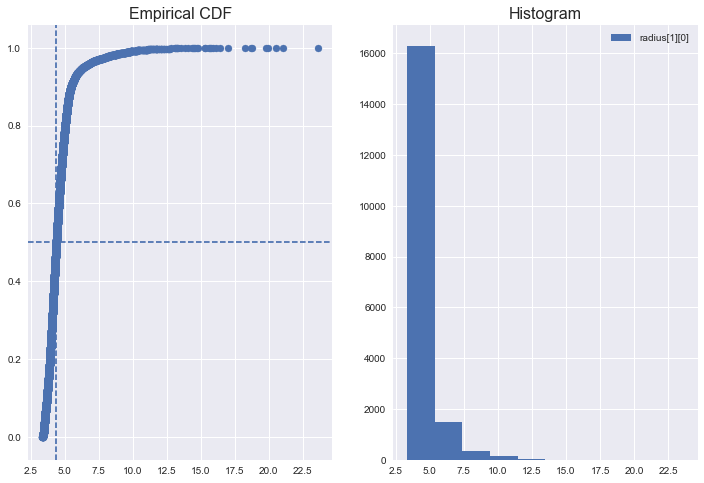

In [38]:
def plot_hist_ecdf(data1d):
    fig = plt.figure(figsize=(12, 8))
    ax_ecdf = fig.add_subplot(121)
    ax_hist = fig.add_subplot(122)
    ax_hist.set_title('Histogram',fontsize=16)

    ax_hist.hist(data1d,bins=10)

    x, y = np.sort(data1d), np.arange(1, len(data1d)+1) / len(data1d)
    
    ax_ecdf.scatter(x, y)
    ax_ecdf.set_title('Empirical CDF',fontsize=16)
    ax_ecdf.axhline(y=0.5,linestyle='--')
    idx = (np.abs(y - 0.5)).argmin()
    ax_ecdf.axvline(x[idx],linestyle='--')

    plt.legend()
    plt.show()
    
plot_hist_ecdf(df_07_10['radius[1][0]'])

In [19]:
import plotly
import plotly.offline as py
import plotly.plotly as pyp
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.tools as tls
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=False)

In [20]:
def plot_hist_ecdf(data):
    x, y = np.sort(data), np.arange(1, len(data)+1) / len(data)
    idx = np.abs(y-0.5).argmin()
    z = x[idx]


    hist0 = go.Histogram(x = data,name='Histogram')
    sc1 = go.Scatter(x=x,y=y,mode = 'markers',name = 'Empirical CDF')
    sc2 = go.Scatter(x=x,y=[0.5]*len(x),mode = 'lines',name = 'y=0.5 (central tendency)')
    sc3 = go.Scatter(x=[z]*1000,y=np.linspace(0,1,1000),mode = 'lines',name = 'x={:.2f}'.format(z))


    fig = plotly.tools.make_subplots(rows=1, cols=2, shared_xaxes=True,
                                    subplot_titles=('Histogram','Empirical CDF'))

    fig.append_trace(hist0, 1, 1)
    fig.append_trace(sc1, 1, 2)
    fig.append_trace(sc2, 1, 2)
    fig.append_trace(sc3, 1, 2)

    fig['layout'].update(height=600, width=800, title='')

    fig.layout.xaxis1.title="value"
    fig.layout.yaxis1.title="count"

    fig.layout.xaxis2.zeroline=False
    fig.layout.xaxis2.title="value"
    fig.layout.yaxis2.title="empirical CDF"

    iplot(fig)
    
np.random.seed(42)
data = df_07_10['radius[1][0]']
plot_hist_ecdf(data)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



# Bucketing equal number of objects in bins after sorting flux

In [21]:
# we want to find flux buckets, so sort the data by flux
df = df.sort_values(by='flux')
print(df.shape)
df.head(2).append(df.tail(2)).iloc[:,-5:]

(183832, 45)


gc[0]    gc[1]          flux     gm_sq     gc_sq
180832  0.13805 -0.21480  3.517335e+03  0.023482  0.065197
24586   0.16295  0.23625  4.517341e+03  0.145381  0.082367
44152  -0.95505  0.05265  4.410982e+06  0.866382  0.914893
182106  0.81545 -0.54430  6.084687e+06  0.948599  0.961221

In [22]:
df.flux.describe()

count    1.838320e+05
mean     1.408668e+05
std      2.657477e+05
min      3.517335e+03
25%      1.771634e+04
50%      3.721008e+04
75%      1.160952e+05
max      6.084687e+06
Name: flux, dtype: float64

In [23]:
iplot(ff.create_table(df.flux.describe().reset_index()))

In [24]:
# we have 183k objects we will distribute them in some bins after sorting flux
N_BUCKETS = 60

dfn = np.array_split(df,N_BUCKETS)

print(dfn[0].shape)

dfn[0].head(2).append(dfn[0].tail(2))

(3064, 45)


fN[0][0]  fN[1][0]  fN[2][0]  fN[3][0]  id[0][0]  id[1][0]  id[2][0]  \
180832        98        98        98        98      7597      7587      7519   
24586         13        13        13        13      3241      3245      3259   
128671        70        70        70        70      4773      4769      4740   
181136        98        98        98        98      6983      6977      6922   

        id[3][0]       x[0]        x[1]    ...     radius[1][0]  radius[2][0]  \
180832      7501  2193.6307  3159.44600    ...         3.477484      3.404743   
24586       3255  1177.8090   467.15318    ...         3.538473      3.455143   
128671      4733  2931.3887  1399.98710    ...         3.427529      3.427274   
181136      6907  2090.4889  3037.07160    ...         3.661106      3.717189   

        radius[3][0]    gm[0]    gm[1]    gc[0]    gc[1]       flux     gm_sq  \
180832      3.423475  0.06375 -0.13935  0.13805 -0.21480  3517.3354  0.023482   
24586       3.523166  0.35400  0.14165  0.16295  0.23625  4517.3414  0.145381   
128671      3.424353  0.74960  0.07930  0.58460  0.08790  8034.8609  0.568189   
181136      3.663793 -0.62740 -0.25245 -0.66180 -0.28595  8034.9350  0.457362   

           gc_sq  
180832  0.065197  
24586   0.082367  
128671  0.349484  
181136  0.519747  

[4 rows x 45 columns]

# Look at the bucket25 with dense population at gmSquared 0.7 to 1.0

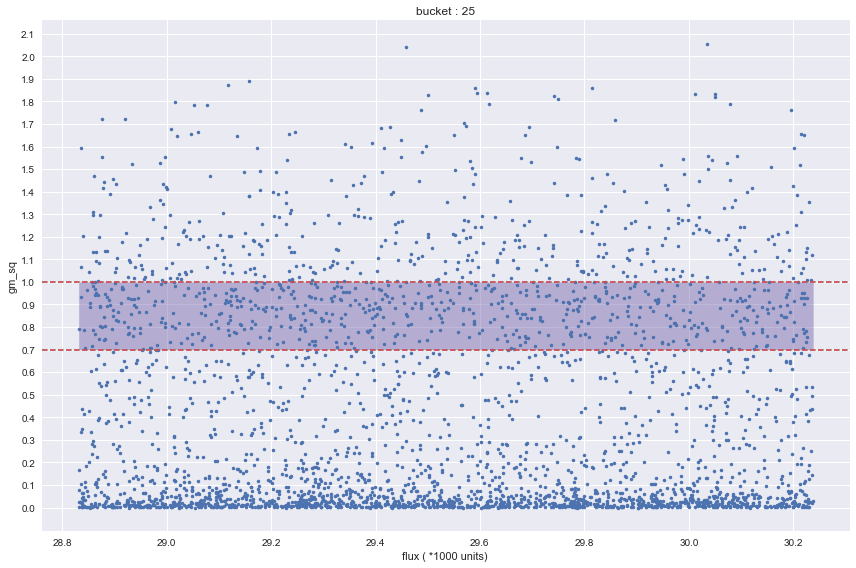

In [25]:
j = 25

plt.figure(figsize=(12,8))
x = dfn[j]['flux'].values/1000 # divide by 1000 just for plotting
y = dfn[j]['gm_sq'].values

plt.plot(x, y, '.')
plt.title('bucket : ' + str(j))
plt.xlabel('flux ( *1000 units) ')
plt.ylabel('gm_sq')

plt.axhline(0.7,c='r',linestyle='--')
plt.axhline(1.0,c='r',linestyle='--')
plt.yticks(np.arange(0,2.2,0.1))

plt.fill_between(x=x,y1=[0.7]*len(x),y2=[1.0]*len(x),color='m',alpha=0.5)

plt.tight_layout()

# Read just one lsst_mono and lsst_mono90 catalog files

Note that m and m9 file have different number of objects detected (rows). In 
imcat we can combine two or more catalogs using `mergecats`, however, in python
there is no easy way of combining nearby objects using some tolerence as like in
mergecats.

In python we can simply append the objects at the bottom, but this gives no any
advantages in object analysis, so I need to create merged catalog using imcat,
then can do analysis using pandas.

```
$ mergecats -u


NAME
	mergecats - merge catalogues of objects by position

SYNOPSIS
	mergecats [options...] d a.cat b.cat ....

DESCRIPTION
	'mergecats' reads N catalogues of objects and outputs a single
	merged catalogue of objects whose positions match to
	within tolerance d.

	We first read all the catalogues
	and then for each object in turn construct an N-tuplet
	consisting of it and any neighbours which meet the
	positional tolerance criterion.  We then rank the N-tuplets
	in order of quality of match (an N-tuplet
	with all slots filled ranks higher than one with one
	empty slot etc., otherwise rank is the sum of the
	N (N - 1) / 2 separations).  We then output the
	N-tuplets (as objects with same named items as
	the input catalogue but where each item is a N-vector
	of the input values) in order of decreasing rank, but
	only using the objects which were not contained in a previously
	output N-tuplet.

	By default, mergecats will only output complete ntuplets (i.e
	those with detections in all input catalogues).

	The idea here is that if one has three input catalogues
	containing positionally coincidental objects B,V,I say, plus
	an extra nearby neighbour N detected in B only,
	then the algorithm will construct four triplets BVI, VIB, IBV and
	NVI, it will then output whichever of the first 3 triplets
	is tightest and then output an extra object N-- with
	two empty slots.

	For efficiency we read the objects from each catalogue into
	a checkerboard grid of null terminated linked lists of objects.
    
Options are:

	-x xname	Supply name for the 2-vector spatial coord ('x')

	-n nmin		Output only objects with >= nmin detections.
			With this it may be useful to use -m option:

	-N nmax		Output only objects with <= nmax detections.
			With this it may be useful to use -m option:

	-m		Prepend the output object items with a mask which
		 	is a binary representation of the detections. E.g
			mask = '10010' indicates a detection in the zeroth
			and third catalogues of a five catalogue merge.
			Leading zeros are not printed.

	-M mask		Output only objects which match the specified mask.

	-s		Prepend the output cat with a column containing
			the 'size' of the object (sum of the N (N - 1) / 2
			separations.

	-d		Prepend the output cat with a column containing
			the number of detections.

	-e		Exclude zero separation ntuplets

AUTHOR
	Nick Kaiser --- kaiser@cita.utoronto.ca
```

In [26]:
!head -20 ../../a08_july5_2019/src_lsst_mono_z1.5_000.cat | grep comment

# comment: # file_number  id  base_SdssCentroid_x  base_SdssCentroid_y  base_SdssCentroid_xSigma  base_SdssCentroid_ySigma  ext_shapeHSM_HsmShapeRegauss_e1  ext_shapeHSM_HsmShapeRegauss_e2  ellip  base_SdssShape_flux  radius
# comment: history: lc -C -n fN -n id -N '1 2 x' -N '1 2 errx' -N '1 2 g' -n ellip -n flux -n radius


In [27]:
# look at just one imcat cat file of mono
!sed -n '15p' ../../a08_july5_2019/src_lsst_mono_z1.5_000.cat

#             fN             id           x[0]           x[1]        errx[0]        errx[1]           g[0]           g[1]          ellip           flux         radius


In [28]:
# look at just one imcat cat file of mono
!sed -n '16p' ../../a08_july5_2019/src_lsst_mono_z1.5_000.cat

               0             43      2075.3294         50.735         0.1003         0.0966         0.4209        -0.6853     0.80423436       6997.766      5.1365195


In [29]:
# look at just one imcat catalog file of mono90
!sed -n '16p' ../../a08_july5_2019/src_lsst_mono90_z1.5_000.cat

               0             43      2076.9302        49.6888          0.254         0.2226          0.484        -0.7114     0.86043359      7295.1804      4.9817134


In [30]:
columns = """fN             id           
x0           x1        
errx0        errx1           
e0           e1        
ellip           flux         radius""".split()

In [31]:
infile = "../../a08_july5_2019/src_lsst_mono_z1.5_000.cat"
df_m0 = pd.read_csv(infile,header=None,comment='#',sep=r'\s+')

print(df_m0.shape)
df_m0.columns = columns
df_m0.head(2).append(df_m0.tail(2))

(2369, 11)


fN    id         x0         x1   errx0   errx1      e0      e1  \
0      0    43  2075.3294    50.7350  0.1003  0.0966  0.4209 -0.6853   
1      0    50  2915.3262    60.5586  0.0654  0.1069 -1.0058  0.1430   
2367   0  7692    57.0659  3370.7583  0.0998  0.0875  0.1641 -0.4045   
2368   0  7693    30.9936  3344.8526  0.0548  0.0571 -0.1478 -0.0407   

         ellip        flux    radius  
0     0.804234   6997.7660  5.136520  
1     1.015915  10343.2780  4.488783  
2367  0.436519   8804.8077  4.142015  
2368  0.153301   7245.2271  3.660545

In [32]:
infile = "../../a08_july5_2019/src_lsst_mono90_z1.5_000.cat"
df_m9 = pd.read_csv(infile,header=None,comment='#',sep=r'\s+')

print(df_m9.shape)
df_m9.columns = columns
df_m9.head(2).append(df_m9.tail(2))

(2311, 11)


fN    id         x0         x1   errx0   errx1      e0      e1  \
0      0    43  2076.9302    49.6888  0.2540  0.2226  0.4840 -0.7114   
1      0    44   468.7871    52.8991  0.0582  0.0641 -0.2109 -1.4296   
2309   0  7695    57.3704  3370.3584  0.1047  0.0880  0.4749 -0.2749   
2310   0  7699    83.2440  3357.5753  0.3311  0.1912  0.8621 -0.0797   

         ellip       flux    radius  
0     0.860434  7295.1804  4.981713  
1     1.445073  6207.0956  3.548051  
2309  0.548726  8934.5454  4.324428  
2310  0.865776  5010.2534  5.640475

In [33]:
df_m = df_m0.append(df_m9)
df_m.head(2).append(df_m.tail(2))

fN    id         x0         x1   errx0   errx1      e0      e1  \
0      0    43  2075.3294    50.7350  0.1003  0.0966  0.4209 -0.6853   
1      0    50  2915.3262    60.5586  0.0654  0.1069 -1.0058  0.1430   
2309   0  7695    57.3704  3370.3584  0.1047  0.0880  0.4749 -0.2749   
2310   0  7699    83.2440  3357.5753  0.3311  0.1912  0.8621 -0.0797   

         ellip        flux    radius  
0     0.804234   6997.7660  5.136520  
1     1.015915  10343.2780  4.488783  
2309  0.548726   8934.5454  4.324428  
2310  0.865776   5010.2534  5.640475

In [34]:
df_m[df_m.index.isin([0,2368])]

fN    id         x0         x1   errx0   errx1      e0      e1  \
0      0    43  2075.3294    50.7350  0.1003  0.0966  0.4209 -0.6853   
2368   0  7693    30.9936  3344.8526  0.0548  0.0571 -0.1478 -0.0407   
0      0    43  2076.9302    49.6888  0.2540  0.2226  0.4840 -0.7114   

         ellip       flux    radius  
0     0.804234  6997.7660  5.136520  
2368  0.153301  7245.2271  3.660545  
0     0.860434  7295.1804  4.981713

In [35]:
# mono and mono90 have different number of rows